In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
base_path = '/content/drive/My Drive/abdb-HW4'

In [11]:
!ls /content/drive/'My Drive'/abdb-HW4

'algotrading model.ipynb'   last_update_17_7_2020.csv   q1-iris_ver2.ipynb
 corona.csv		    q1-iris.ipynb	        q2-covid19.ipynb


In [12]:
import pandas as pd
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split

In [13]:
corona = pd.read_csv(os.path.join(base_path, 'corona.csv'))
corona_new = pd.read_csv(os.path.join(base_path, 'last_update_17_7_2020.csv'))

In [14]:
print(corona_new.keys())

Index(['date', 'tests', 'positive', 'pred_date', 'pred_tests',
       'pred_positive'],
      dtype='object')


In [15]:
tests = corona_new['tests'].to_numpy()
positive = corona_new['positive'].to_numpy()
date = len(corona_new['date'].to_numpy())
precent = (positive*100)/tests

pred_date = 18
pred_tests = corona_new['pred_tests'][0:18].to_numpy()
pred_positive = corona_new['pred_positive'][0:18].to_numpy()

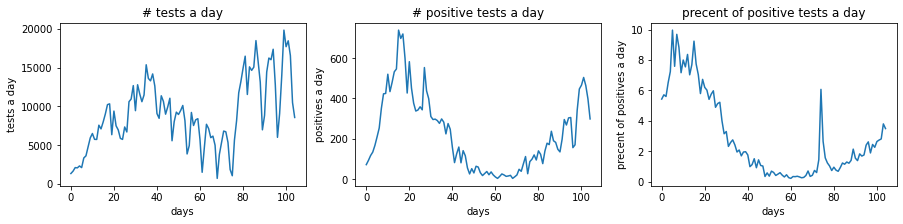

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
ax[0].set_title('# tests a day')
ax[1].set_title('# positive tests a day')
ax[2].set_title('precent of positive tests a day')
ax[0].set_ylabel('tests a day')
ax[1].set_ylabel('positives a day')
ax[2].set_ylabel('precent of positives a day')
ax[0].set_xlabel('days')
ax[1].set_xlabel('days')
ax[2].set_xlabel('days')
ax[0].plot(range(date),tests)
ax[1].plot(range(date),positive)
ax[2].plot(range(date),(positive*100)/tests)

In [1]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [16]:
tests = corona_new['tests'].to_numpy()
positive = corona_new['positive'].to_numpy()
day = len(corona_new['date'].to_numpy())
precent = (positive*100)/tests

pred_date = 18
pred_tests = corona_new['pred_tests'][0:18].to_numpy()
pred_positive = corona_new['pred_positive'][0:18].to_numpy()

FOR THE TESTS PREDICTION ! 

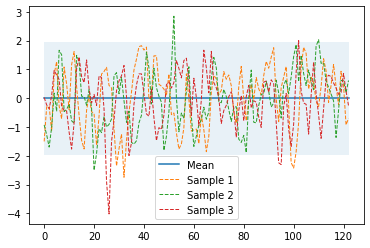

In [50]:
%matplotlib inline

# Finite number of points - tests per day 
X = np.array(range(len(tests)+pred_date)).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

In [51]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

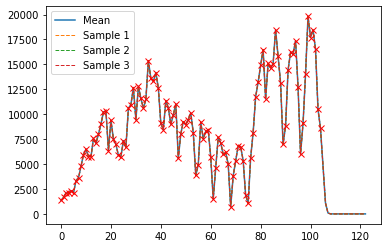

In [52]:
# Noise free training data
X_train = np.array(range(len(tests))).reshape(-1, 1)
Y_train = tests.reshape(-1, 1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

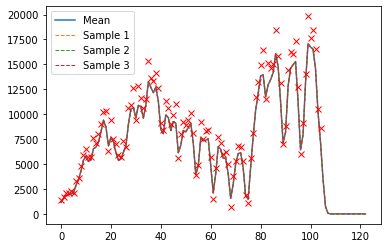

In [53]:
noise = 0.5

# Noisy training data
X_train = np.array(range(len(tests))).reshape(-1, 1)
Y_train = tests.reshape(-1, 1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

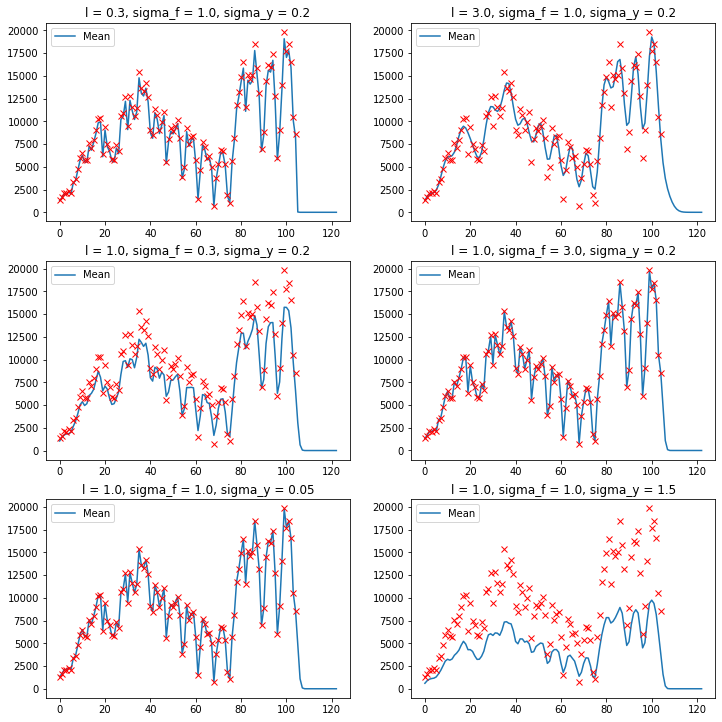

In [54]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

FOR THE POSITIVE PREDICTIONS 

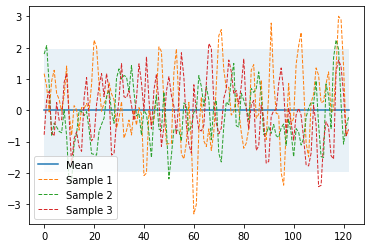

In [62]:
%matplotlib inline

# Finite number of points - tests per day 
X = np.array(range(len(positive)+pred_date)).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

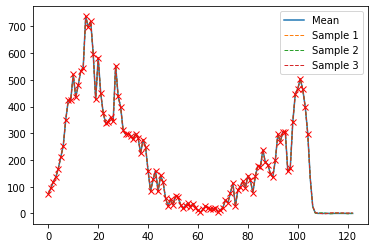

In [64]:
# Noise free training data
X_train = np.array(range(len(positive))).reshape(-1, 1)
Y_train = positive.reshape(-1, 1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

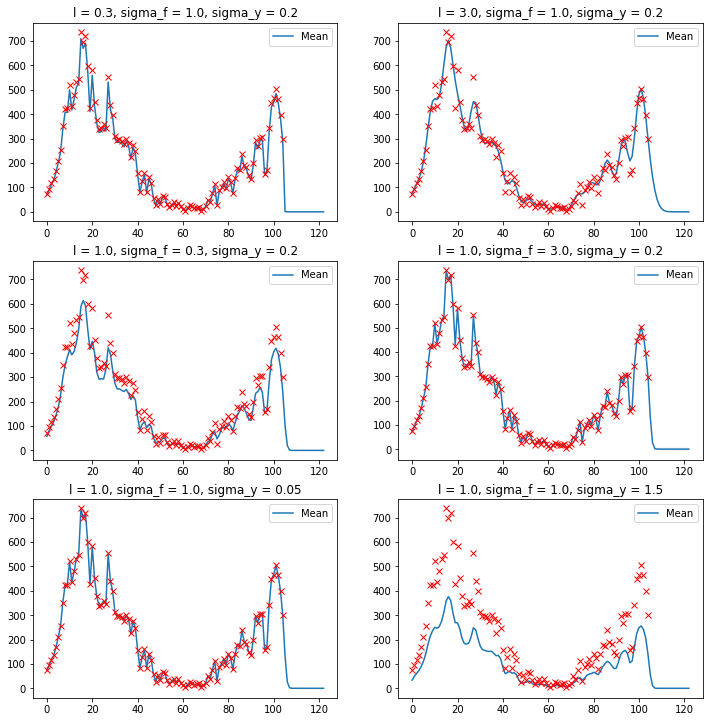

In [65]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

As we can see, the model predicts a decline in the tests and positive samples. Hopefully, it will happen soon too! 
Another thing I want to say is that I tried many methods, and none of them gave a sufficient prediction (Fourier series, gp in stan didn't stop it's running, Taylor series and more ... )
This is the best results I got even they are optimistic but probably not so right given the next few days data I collected...

In [67]:
print("next few days data I collected using N12 Israeli news")
print("Number of tests")
print(pred_tests)
print("Number of positives")
print(pred_positive)

next few days data I collected using N12 Israeli news
Number of tests
[21015. 20836. 21460. 25039. 20950. 17306. 21093. 25592. 28594. 29385.
 30043. 25761. 20377. 21727. 29184. 31678. 30539. 29504.]
Number of positives
[ 750.  780.  966. 1139.  938.  819.  830. 1132. 1384. 1321. 1521. 1405.
 1161. 1239. 1719. 1595. 1862. 1819.]
